In [1]:
import time
start_time=time.time()

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import lmfit
from scipy import interpolate
import pickle

from bfunc import bfunc00,bfunc01,bfunc02

Data load and region parameters

In [3]:
data = json.load(open("SFdata//HV.json"))

pixscale = 0.26 # arcsec
pixscale *= 2.4              # parsec
s0 = 2.4/2.355                    # parsec
m = 1.4

In [4]:
r = pixscale * 10**np.array(data["log10 r"])
rgrid = pixscale * np.logspace(0.0, 2)

B = np.array(data["Unweighted B(r)"])

sig2 = data["Unweighted sigma^2"]
r0 = np.interp(sig2, B, r)

(7.864699245044958, 2.7843278955912263)

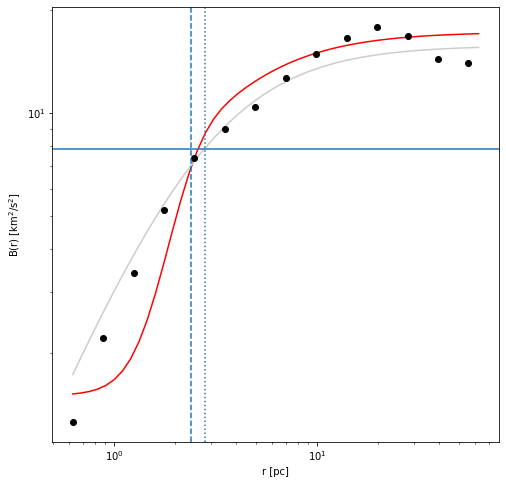

In [5]:
fig, ax = plt.subplots(figsize=(8, 8))
# Plot fit to unweighted strucfunc
ax.plot(rgrid, bfunc02(rgrid, r0, sig2, m, s0, 1.5), color="red")
ax.plot(rgrid, bfunc00(rgrid, r0, sig2, m), color="0.8")
# Plot points from unweighted strucfunc
ax.plot(r, B, 'o',  color='black')

ax.axhline(sig2)
ax.axvline(2.355 * s0, linestyle="dashed")
ax.axvline(r0, linestyle="dotted")

ax.set(
    xscale = "log",
    yscale = "log",
#    ylim  = [1, 250],
#    xlim  = [1, 150],
    xlabel = "r [pc]",
    ylabel = r"B(r) [km$^{2}$/s$^{2}$]",
)

sig2,r0

In [6]:
model02 = lmfit.Model(bfunc02)
model02.param_names

['r0', 'sig2', 'm', 's0', 'noise']

In [7]:
relative_uncertainty = 0.10
weights = 1.0 / (relative_uncertainty * B)
weights[r > r0] /= 2.0

In [8]:
for p in model02.param_names:
    model02.set_param_hint(p, min=0.0)
#model02.set_param_hint("sig2", value=sig2, vary=False)
#model02.set_param_hint("s0", min=1.0)
model02.print_param_hints()

Name      Value      Min      Max     Vary    Expr    
m           nan        0      inf     True    
noise       nan        0      inf     True    
r0          nan        0      inf     True    
s0          nan        0      inf     True    
sig2        nan        0      inf     True    


In [9]:
result2 = model02.fit(
    B, 
    weights=weights,
    r=r, r0=r0, m=m, s0=s0, noise=1.0, sig2=sig2
)

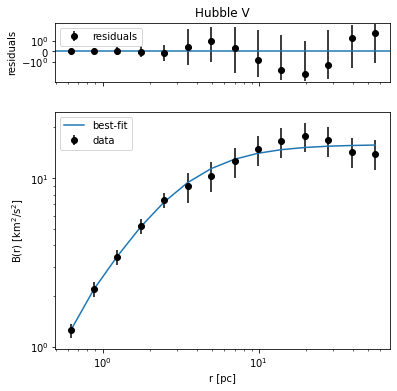

In [10]:
fig, _ = result2.plot( 'ko')
fig.axes[0].set(
    title='Hubble V',
    xscale="log",
    yscale="symlog",
)
fig.axes[1].set(
    xscale = "log",
    yscale = "log",
    xlabel = "r [pc]",
    ylabel = r"B(r) [km$^{2}$/s$^{2}$]",
);

plt.savefig('SFpaper//Hubble V.pdf', bbox_inches='tight')




In [11]:
print(result2.fit_report())

[[Model]]
    Model(bfunc02)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 119
    # data points      = 14
    # variables        = 5
    chi-square         = 1.99784796
    reduced chi-square = 0.22198311
    Akaike info crit   = -17.2578145
    Bayesian info crit = -14.0625278
[[Variables]]
    r0:     2.78758789 +/- 0.21757068 (7.80%) (init = 2.784328)
    sig2:   7.88046482 +/- 0.77787000 (9.87%) (init = 7.864699)
    m:      1.62076632 +/- 0.30185699 (18.62%) (init = 1.4)
    s0:     0.23085982 +/- 0.09623229 (41.68%) (init = 1.019108)
    noise:  0.09922580 +/- 0.94783062 (955.23%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(s0, noise)   =  0.959
    C(m, noise)    =  0.949
    C(sig2, m)     = -0.928
    C(sig2, noise) = -0.893
    C(m, s0)       =  0.845
    C(sig2, s0)    = -0.819
    C(r0, s0)      =  0.433
    C(r0, noise)   =  0.326


In [12]:
#for p in result2.model.param_names:
#    result2.params[p].stderr = result2.params[p].value * 0.1

In [13]:
result2.conf_interval()
print(result2.ci_report())

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:312: UserWarning: Bound reached with prob(s0=0.0) = 0.619659020217232 < max(sigmas)
  warn(errmsg)
C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:312: UserWarning: Bound reached with prob(noise=0.0) = 0.09125911218137023 < max(sigmas)
  warn(errmsg)


          99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 r0   :  -0.65863  -0.41687  -0.20900   2.78759  +0.35784  +0.81567  +1.83477
 sig2 :  -1.81476  -1.22344  -0.75294   7.88046  +0.44807  +0.92466  +1.65141
 m    :  -0.39001  -0.23543  -0.12369   1.62077  +0.28728  +0.49801  +0.74980
 s0   :      -inf      -inf      -inf   0.23086  +0.15735  +0.22891  +0.33274
 noise:      -inf      -inf      -inf   0.09923  +0.88950  +1.06404  +1.24082


In [14]:
plt.style.use([
    "seaborn-poster",
])

In [15]:
plot_limits = {
    "s0": [0.0, 0.8],
    "m": [1.0, 2.2],
    "r0": [1.0, 5.0],
    "noise": [0.0, 2.0],
    "sig2": [5, 9],
}

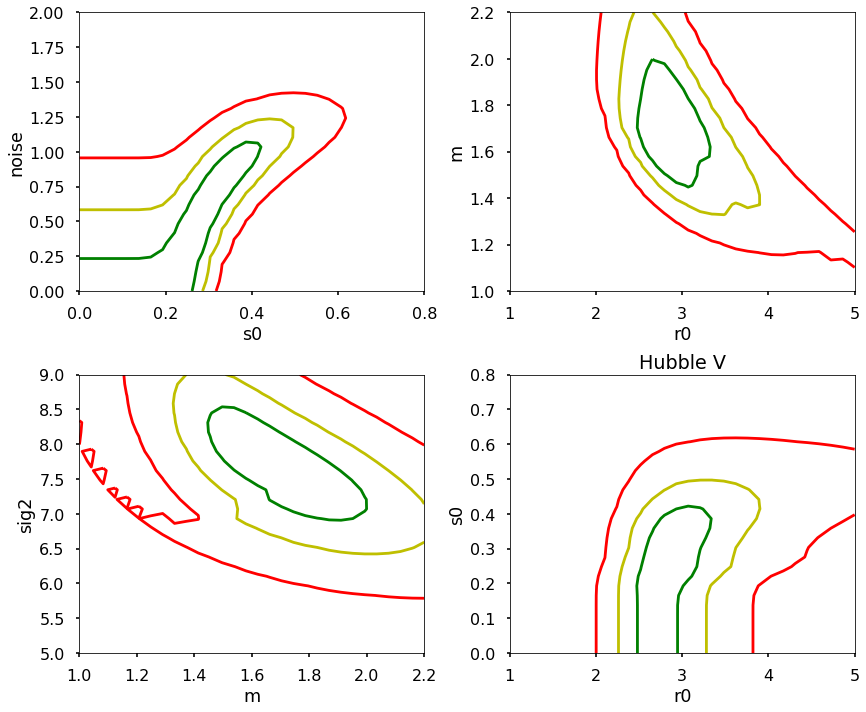

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

plt.title('Hubble V')
levels = [0.6827, 0.9545, 0.9973]
colors = ["g", "y", "r"]

for ax, [xvar, yvar] in zip(axes.flat, [
    ["s0", "noise"],
    ["r0", "m"],
    ["m", "sig2"],
    ["r0", "s0"],
]):
    cx, cy, grid = lmfit.conf_interval2d(
        result2, result2, xvar, yvar, 30, 30,
        limits=[plot_limits[xvar], plot_limits[yvar]],
    )
    ctp = ax.contour(cx, cy, grid, levels, colors=colors)
    ax.set_xlabel(xvar)
    ax.set_ylabel(yvar)

fig.tight_layout();

In [17]:
x=r
y=B-2*sig2
tck=interpolate.splrep(x,y,s=0)
grid=np.linspace(x.min(),x.max(),num=len(x))
ynew=interpolate.splev(grid,tck,der=0)
inter=pd.DataFrame([grid,ynew]).T
SFr=interpolate.sproot(tck)
SFr

array([11.61832444, 32.46514122])

In [18]:
r.max()/result2.params['r0'].value

19.950602748705393

In [19]:
(r[3]/2**0.5)*((result2.params['r0'].value/r[3])**(result2.params['m'].value/2))

1.806266652184825

In [20]:
#f = open('CI//HV.pkl',"wb")
#pickle.dump(result2,f)
#f.close()

In [21]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 38.433032751083374 seconds ---
